# Exercise 9 - Spectral Doppler

In [147]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.signal import convolve2d, lfilter, firwin, freqz
from scipy.signal.windows import hamming, boxcar

# Data import and extraction:

importData = loadmat("./slowmotion_v2.mat")

iq = importData["iq"]

parameters = importData["pars"]
fps = parameters[0,0]["fps"].item()
f0 = parameters[0,0]["f0"].item()

depthStart = parameters[0,0]["depth_start"].item()
depthIncrement = parameters[0,0]["depth_inc"].item()
depthEnd = depthStart + depthIncrement*iq.shape[0]

zAxis = np.arange(depthStart, depthEnd, depthIncrement)*1e3
tAxis = np.arange(0, iq.shape[2]/fps, 1/fps)

centerBeam = iq[:,round(iq.shape[1]/2),:]

def estimateSpectrum(signal, fps, N, logNormalize=True):
    spectrum = np.abs(np.fft.fft(signal, N))**2
    spectrum = np.fft.fftshift(spectrum)
    if logNormalize:
        spectrum = 10*np.log10(spectrum)
        spectrum -= np.max(spectrum)
    freqs = np.linspace(-fps/2, fps/2, N)
    return freqs, spectrum


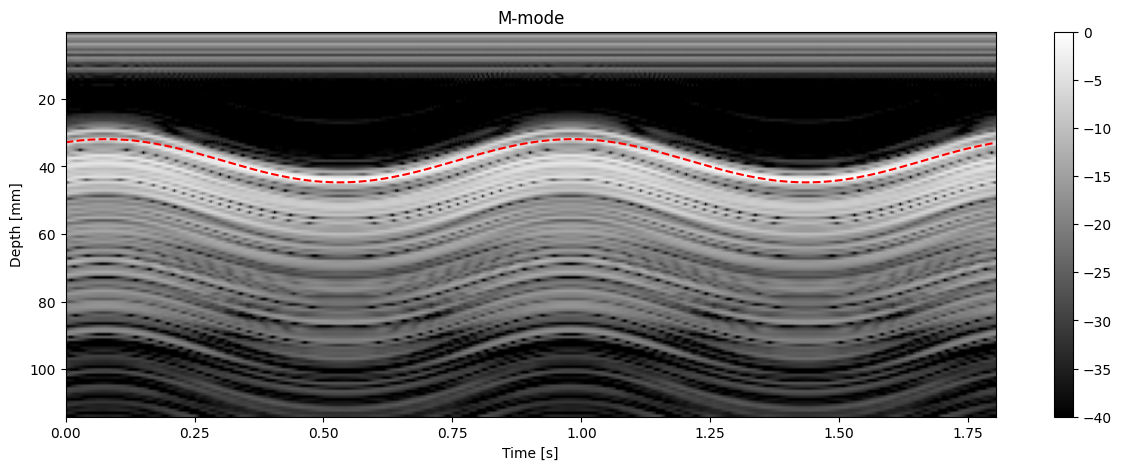

In [81]:
# M-mode vizualization:

mMode = np.abs(centerBeam)**2
mModeLog = 10*np.log10(mMode)
mModeLog -= np.max(mModeLog)

extent = np.array([tAxis[0], tAxis[-1], zAxis[-1], zAxis[0]])

plt.figure(figsize=(15,5))
plt.imshow(mModeLog, cmap="gray", extent=extent, aspect="auto", vmin=-40, vmax=0)
plt.colorbar()
plt.xlabel("Time [s]")
plt.ylabel("Depth [mm]")
plt.title("M-mode")

# Estimating motion parameters:
R = 6.4e-3
# L = 10e-2
t0 = 0.079
T = 0.905
z0 = 3.83e-2
r = -R * np.cos((2*np.pi*(tAxis-t0)) / T) + z0
rPeak = np.min(r)
# plt.plot([t0, t0 + T], [rPeak*1e3, rPeak*1e3], 'y-')
plt.plot(tAxis, r*1e3, 'r--')

plt.show()


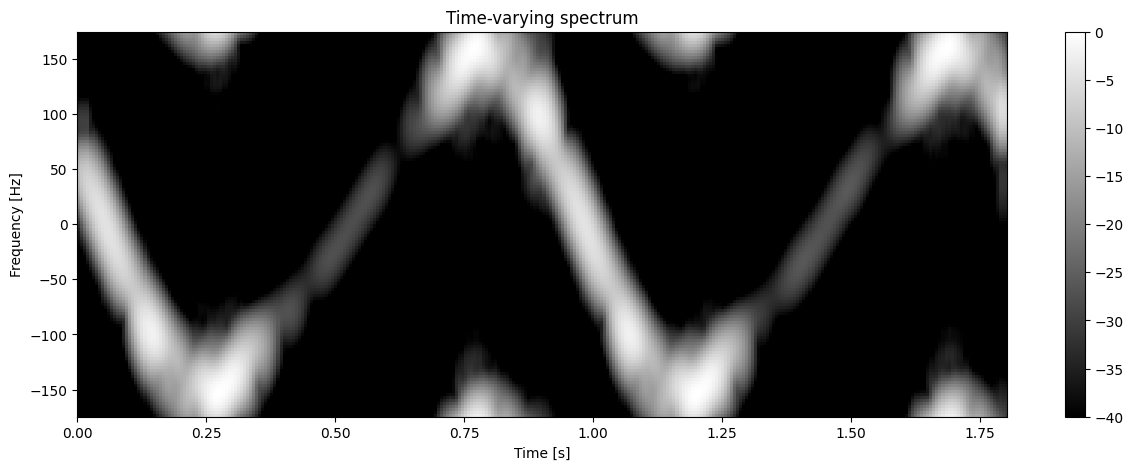

In [149]:
# Time-varying display of spectral analysis:

z0 = 3.83e-2
z0Index = np.argmin(np.abs((zAxis*1e-3) - z0))
centerBeamZ0 = centerBeam[z0Index, :]


# Generate time-varying spectrum w/ overlap

windowLength = 16
Nfft = 128
overlap = 0.1

timeWindows = np.arange(0, len(tAxis) - windowLength + 1, round(windowLength * overlap))
spectra = np.zeros((Nfft, len(timeWindows)))

for k, w in enumerate(timeWindows):
    signal = centerBeamZ0[np.arange(0, windowLength) + w]
    signal *= hamming(windowLength)
    freqs, logSpectrum = estimateSpectrum(signal, fps, Nfft, logNormalize=False)
    spectra[:, k] = logSpectrum


# Sliding window averaging:

averagingWindowLength = 6
smoothedSpectra = convolve2d(spectra, np.ones((1, averagingWindowLength))/averagingWindowLength, mode="same")
smoothedSpectra /= np.max(smoothedSpectra.flatten())
smoothedSpectra = 10*np.log10(smoothedSpectra + np.finfo(np.float32).eps)


# Plot sonogram:

plt.figure(figsize=(15,5))
plt.imshow(smoothedSpectra, aspect='auto', cmap='gray', vmin=-40, vmax=0, extent=np.array([tAxis[0], tAxis[-1], freqs[0], freqs[-1]]))
# frequency = -4 * np.pi * f0 * (R/T * np.sin(2*np.pi*(tAxis-t0)/T)) / 1490
# plt.plot(tAxis, frequency, "r--")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.title("Time-varying spectrum")
plt.colorbar()
plt.show()


## Observations (9.1)

a)

Comparing the time-varying spectrum output to that from exercise 8 (no overlapping/averaging. Attached as comparison.png), we see that the Welch approach gives us a smoother looking image.

b)

Greater overlap and more averaged samples both contribute to making the image more smooth. The resulting image looks quite sharp, with good contrast between light and dark regions and fairly clear and smooth edges.

c)

8 samples per window is too little. Even though we get high time localization, we see the image looks "smeared" in the frequency direction (poor frequency- vs. time resolution).

64 samples is a bit too much. The long window makes the resulting image look a bit "choppy".

16 samples and 32 samples both look quite good with a decent tradeoff between time- and frequency resolution. It's hard to say which is better, but with 32 samples it looks like we get the most balanced image when comparing the resolution in the two directions.

In [150]:
# Import cluttered data

importData = loadmat("./slowmotion_clutter_v2.mat")

iq = importData["iq"]

parameters = importData["pars"]
fps = parameters[0,0]["fps"].item()
f0 = parameters[0,0]["f0"].item()

depthStart = parameters[0,0]["depth_start"].item()
depthIncrement = parameters[0,0]["depth_inc"].item()
depthEnd = depthStart + depthIncrement*iq.shape[0]

zAxis = np.arange(depthStart, depthEnd, depthIncrement)*1e3
tAxis = np.arange(0, iq.shape[2]/fps, 1/fps)

centerBeam = iq[:,round(iq.shape[1]/2),:]

# Time-varying display of spectral analysis:

z0 = 3.83e-2
z0Index = np.argmin(np.abs((zAxis*1e-3) - z0))


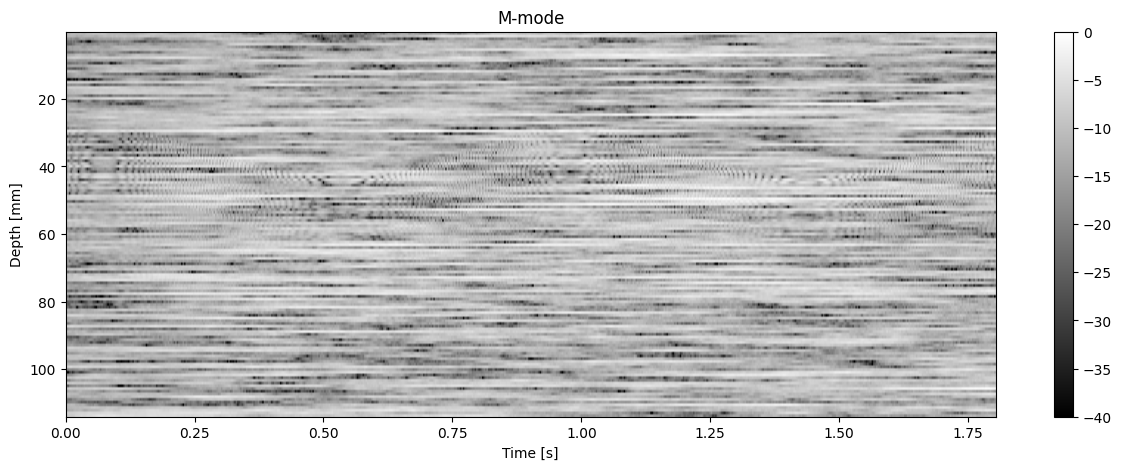

In [151]:
# Generate M-mode

mMode = np.abs(centerBeam)**2
mModeLog = 10*np.log10(mMode)
mModeLog -= np.max(mModeLog)

plt.figure(figsize=(15,5))
plt.imshow(mModeLog, cmap="gray", extent=np.array([tAxis[0], tAxis[-1], zAxis[-1], zAxis[0]]), aspect="auto", vmin=-40, vmax=0)
plt.colorbar()
plt.xlabel("Time [s]")
plt.ylabel("Depth [mm]")
plt.title("M-mode")
plt.show()


## Observations (9.2)

a)

It's difficult to make out anything from the M-mode image. The motion is no longer discernible since the stationary signal overpowers it.

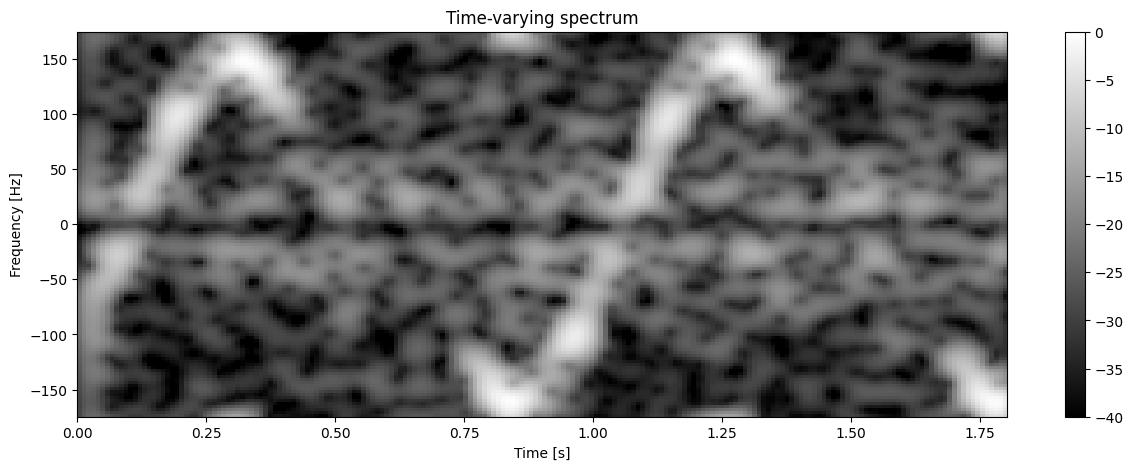

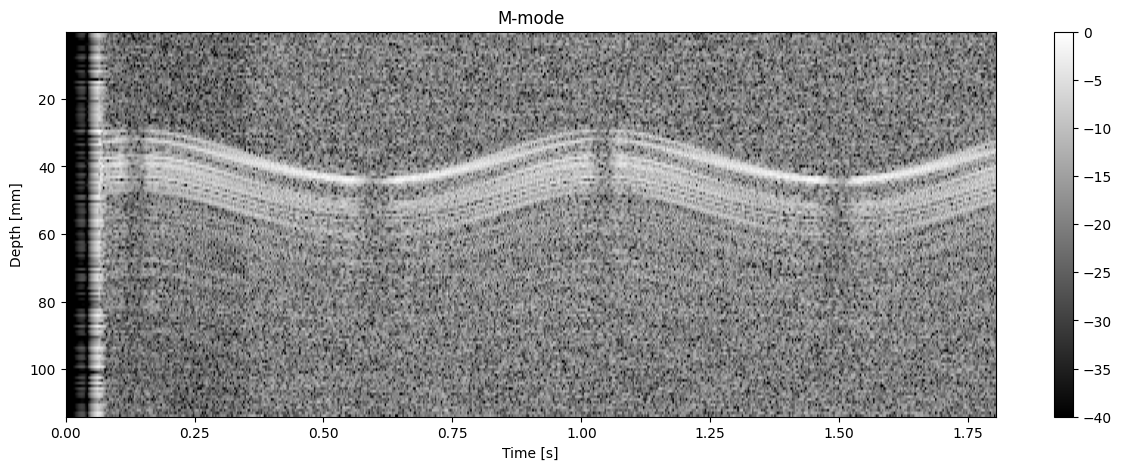

In [152]:
centerBeamZ0 = centerBeam[z0Index, :]

# Generate sonogram

windowLength = 32
Nfft = 128
overlap = 0.1

timeWindows = np.arange(0, len(tAxis) - windowLength + 1, round(windowLength * overlap))
spectra = np.zeros((Nfft, len(timeWindows)))

applyFIR = True
if applyFIR:
    fir = firwin(45, 0.09, pass_zero=False)
    centerBeamZ0 = lfilter(fir, 1, centerBeamZ0)

for k, w in enumerate(timeWindows):
    signal = centerBeamZ0[np.arange(0, windowLength) + w]
    signal *= hamming(windowLength)
    freqs, spectrum = estimateSpectrum(signal, fps, Nfft, logNormalize=False)
    spectra[:, k] = spectrum

# Sliding window averaging:

averagingWindowLength = 4
smoothedSpectra = convolve2d(spectra, np.ones((1, averagingWindowLength))/averagingWindowLength, mode="same")
smoothedSpectra /= np.max(smoothedSpectra.flatten())
smoothedSpectra = 10*np.log10(smoothedSpectra + np.finfo(np.float32).eps)

# Plot sonogram:

plt.figure(figsize=(15,5))
plt.imshow(smoothedSpectra, aspect='auto', cmap='gray', vmin=-40, vmax=0, extent=np.array([tAxis[0], tAxis[-1], freqs[0], freqs[-1]]))
# frequency = -4 * np.pi * f0 * (R/T * np.sin(2*np.pi*(tAxis-t0)/T)) / 1490
# plt.plot(tAxis, frequency, "r--")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.title("Time-varying spectrum")
plt.colorbar()
plt.show()

plotMMode = True
if plotMMode:
    mMode = np.abs(lfilter(fir, 1, centerBeam))**2
    mModeLog = 10*np.log10(mMode)
    mModeLog -= np.max(mModeLog)
    plt.figure(figsize=(15,5))
    plt.imshow(mModeLog, cmap="gray", extent=np.array([tAxis[0], tAxis[-1], zAxis[-1], zAxis[0]]), aspect="auto", vmin=-40, vmax=0)
    plt.colorbar()
    plt.xlabel("Time [s]")
    plt.ylabel("Depth [mm]")
    plt.title("M-mode")
    plt.show()


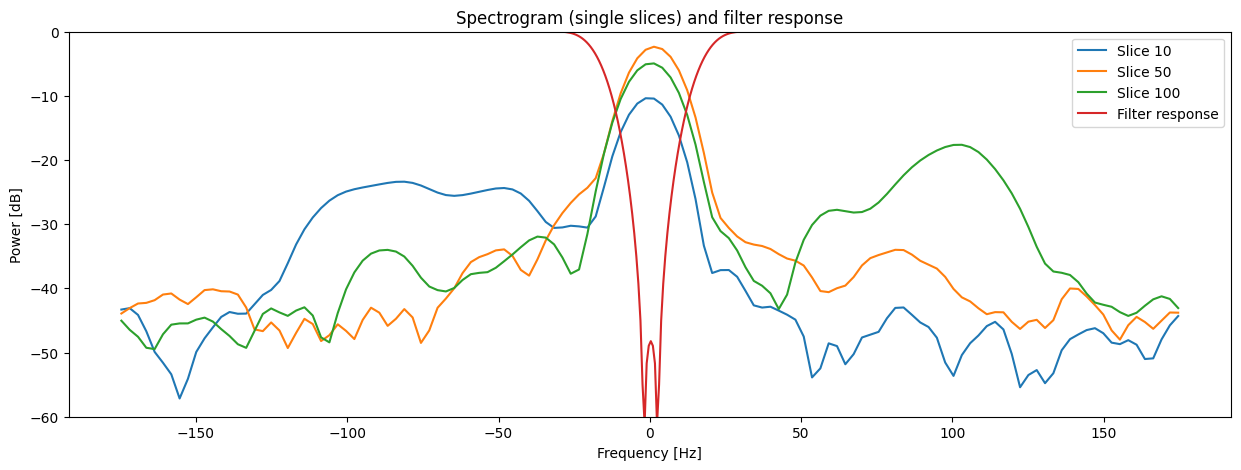

In [131]:
# Plot frequency response of single slice and filter response:

fir = firwin(45, 0.09, pass_zero=False)
w, h = freqz(fir, whole=True)
h = np.fft.fftshift(h)
H = 20*np.log10(np.abs(h))

plt.figure(figsize=(15,5))

sliceIndices = [10, 50, 100]
[plt.plot(freqs, smoothedSpectra[:, i]) for i in sliceIndices]
plt.plot(np.linspace(freqs[0], freqs[-1], len(H)), H)
# filterMaxAttenuation = np.min(H)
# plt.plot([-10, 10], [filterMaxAttenuation, filterMaxAttenuation], "r--")
plt.title("Spectrogram (single slices) and filter response")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power [dB]")
plt.ylim([-60, 0])
plt.legend([f"Slice {i}" for i in sliceIndices] + ["Filter response"])
plt.show()

## Observations (9.2)

b)

In the sonogram, we see the brighest part of the image is a straight line at 0Hz (stationary signal). The motion is still visible, but it's significantly weaker compared to the stationary response.

c)

With a longer time window we see the bright line around 0Hz becomes thinner. It also appears the motion is easier to make out with a window length of 32 (compared to 16 from earlier) since the contrast between the motion signal we care about and the background is better and the brightness of the motion is slightly better.

d)

The boxcar window function is not smooth tapering. In the sonogram using boxcar window instead of hamming we can clearly see the sidelobes from the stationary signal (response from clutter components). These sidelobes interfere with the motion making it harder to discern.

e)

The clutter to be filtered out is centered at 0Hz, while our motion seems to be closer to ~75Hz-100Hz. From comparing the relative heights of the different peaks in the frequency response, we see that the stop-band attenuation needs to be ~45dB if we want to supress the 0Hz peak down into the noise floor (peak is ~-10dB, while bottom of plot is ~-55dB).

For the nice symmetry of it, let's try and design a filter with a cutoff frequency of 45Hz and a stop-band attenuation of -45dB which should suppress the clutter well.

g)

We see that after filtering, the motion is visible in both the M-mode image and the sonogram. In other words: The high pass filter does what it's supposed to! 

f0: 2.50E+06Hz
PRF: 2.50E+03Hz
fs: 1.00E+07Hz


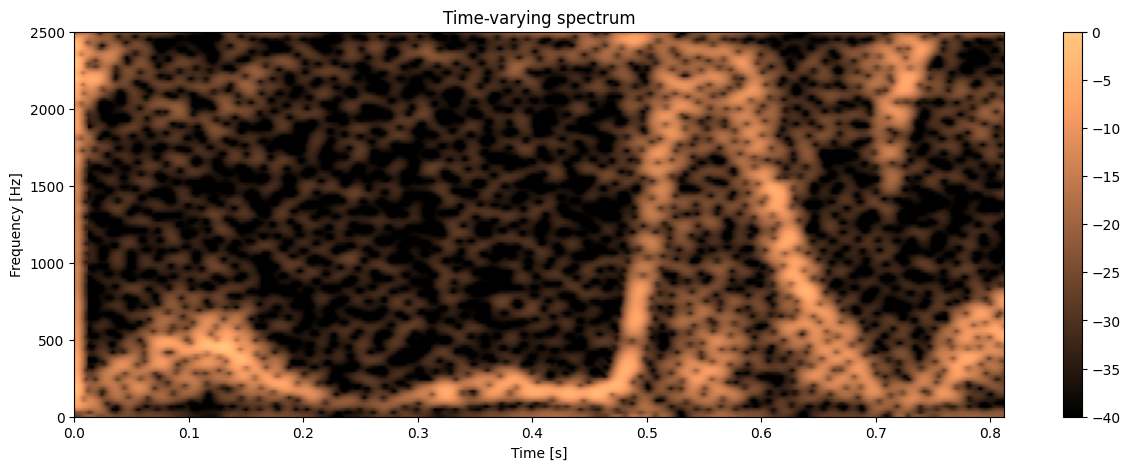

In [207]:
# Import doppler data

importData = loadmat("./Dopplerdata_v2.mat")

iq = importData["iq"]

parameters = importData["pars"]
PRF = parameters[0,0]["PRF"].item()
f0 = parameters[0,0]["f0"].item()
fs = parameters[0,0]["fs"].item()

print(f"f0: {f0:.2E}Hz")
print(f"PRF: {PRF:.2E}Hz")
print(f"fs: {fs:.2E}Hz")

zAxis = np.arange(depthStart, depthEnd, depthIncrement)*1e3
tAxis = np.arange(0, iq.shape[1]/PRF, 1/PRF)

# Time-varying display of spectral analysis:

z0Index = 50
centerBeamZ0 = iq[z0Index, :]

# Configure estimator:

Nfft = 128
overlap = 0.05      # no filter: 0.05. with filter: xx
windowLength = 64   # no filter: 64. with filter: xx


applyFIR = True
plotMMode = False
shiftBaseline = True

# Generate time-varying spectrum w/ overlap

timeWindows = np.arange(0, len(tAxis) - windowLength + 1, round(windowLength * overlap))
spectra = np.zeros((Nfft, len(timeWindows)))

if applyFIR:
    fir = firwin(45, 0.09, pass_zero=False)
    centerBeamZ0 = lfilter(fir, 1, centerBeamZ0)

for k, w in enumerate(timeWindows):
    signal = centerBeamZ0[np.arange(0, windowLength) + w]
    signal *= hamming(windowLength)
    freqs, spectrum = estimateSpectrum(signal, PRF, Nfft, logNormalize=False)
    spectra[:, k] = spectrum


# Sliding window averaging:

averagingWindowLength = 4
averagingWindow = np.ones((1, averagingWindowLength))/averagingWindowLength
smoothedSpectra = convolve2d(spectra, averagingWindow, mode="same")
smoothedSpectra /= np.max(smoothedSpectra.flatten())
smoothedSpectra = 10*np.log10(smoothedSpectra + np.finfo(np.float32).eps)


# Shift baseline

if shiftBaseline:
    baseline = 0.5  # [0-1] Shift baseline (fraction of PRF)
    shiftedSpectra = np.roll(smoothedSpectra, round(baseline * smoothedSpectra.shape[0]), axis=0)
    shiftedMinFrequency = baseline * PRF - PRF/2
    shiftedMaxFrequency = PRF/2 + baseline * PRF

# Plot sonogram:

plt.figure(figsize=(15,5))
plt.title("Time-varying spectrum")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")

if shiftBaseline:
    plt.imshow(np.flip(shiftedSpectra, axis=0), aspect="auto", cmap="copper", vmin=-40, vmax=0, extent=np.array([tAxis[0], tAxis[-1], shiftedMinFrequency, shiftedMaxFrequency]))
else:
    plt.imshow(np.flip(smoothedSpectra, axis=0), aspect="auto", cmap="copper", vmin=-40, vmax=0, extent=np.array([tAxis[0], tAxis[-1], freqs[0], freqs[-1]]))

plt.colorbar()

if plotMMode:
    if applyFIR:
        mMode = np.abs(lfilter(fir, 1, iq))**2
    else:
        mMode = np.abs(iq)**2
    mModeLog = 10*np.log10(mMode)
    mModeLog -= np.max(mModeLog)
    plt.figure(figsize=(15,5))
    plt.title("M-mode")
    plt.xlabel("Time [s]")
    plt.ylabel("Depth [mm]")
    plt.imshow(mModeLog, cmap="gray", extent=np.array([tAxis[0], tAxis[-1], zAxis[-1], zAxis[0]]), aspect="auto", vmin=-40, vmax=0)
    plt.colorbar()

plt.show()

## Observations (9.4)

a)

The first arrow points to a stationary signal (clutter component). It is quite strong compared to the rest of the image.
The second arrow points to an area where we can clearly see the sidelobes of the clutter component.
The last arrow points to an area where we can see the signal coming from the moving blood and an aliased "copy".

c)

The initial filter settings actually work quite well. Most of the clutter component is gone, and after reducing the dynamic range from -60dB down to -40dB we see that the desired motion signal is what is most prominent. Some of the clutter component remains, but it looks to be at about the same level as the background so trying to remove it further would most likely also get rid of some of the blood signal.

d)

Using Nyquist to find the maximum measurable velocity:

`vMax = (c * PRF) / (4 * f0)`

`vMax = (1540m/s * 2.5e3Hz) / (4 * 2.5e6Hz)`

`vMax = 0.385m/s`

e)

Looking at the shifted image, the flow has its maximum close to the highest frequency (Which is now `PRF = 2.5MHz`, since we shifted the baseline by PRF/2).
We already calculated the equivalent velocity for half of this in `d)`; the maximum velocity of the flow is roughly `0.385m/s * 2 = 0.77m/s ~ 80cm/s`.

To find the PRF required to measure this velocity *without* shifting the baseline, we can rearrange the Nyquist equation from before:

`vMax = (c * PRF) / (4 * f0) <=> PRF = (4 * f0 * vMax) / c`

`PRF = (4 * 2.5e6Hz * 0.8m/s) / 1540`

`PRF = 5194.8Hz ~ 5.2KHz`